In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
cd ..

/home/anindya/Documents/MachineLearning/SignLangGNN


In [3]:
import torch
import torch.nn as nn

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from src.utils import HandPosUtils
from src.dataset import HandPosDataset
from Models.base_gnn_model import Model

In [6]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [7]:
hand_conn = mp_hands.HAND_CONNECTIONS
source_index = []
target_index = []

for i, j in list(hand_conn):
    source_index.append(i)
    target_index.append(j)

edge_index = np.array([
    source_index,
    target_index
])

edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

In [8]:
model = Model(3, 64, 32, 29).to(device)

In [9]:
path = os.getcwd()
model_path = os.path.join(path, "saved_models/base_model.pth")
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [10]:
handpos = HandPosUtils()
label_dict = handpos.get_label_dict()

### **Testing with a single sample Image**

In [11]:
test_image_path = os.path.join(os.getcwd(), "ImageData/asl_alphabet_test/")

In [12]:
images = os.listdir(test_image_path)
sample_image = os.path.join(test_image_path, images[6])

In [13]:
image = cv2.imread(sample_image)
label = images[6].split('_')[0]

Text(0.5, 1.0, 'G')

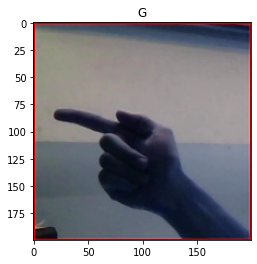

In [14]:
plt.imshow(image)
plt.title(label)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


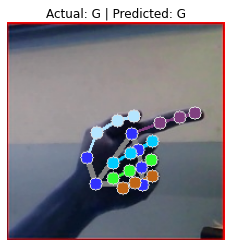

In [15]:
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    image = cv2.flip(cv2.imread(sample_image), 1)
    annotated_image = image.copy()
    
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS,
              mp_drawing_styles.get_default_hand_landmarks_style(),
              mp_drawing_styles.get_default_hand_connections_style())
        
        pos_dict = handpos.get_hand_coords_frame(hand_landmarks)
        x = torch.tensor(np.array(list(pos_dict.values())).reshape(21, 3), dtype=torch.float32).to(device)
        out = model(x, edge_index, torch.tensor([0]))
        predictions = out.argmax(dim=1).item()
        predicted_letter = list(label_dict.keys())[list(label_dict.values()).index(predictions)]
        
        
    plt.imshow(annotated_image)
    plt.title(f"Actual: {label} | Predicted: {predicted_letter}")
    plt.axis('off')

### Test with Real time images

In [16]:
test_path = os.path.join(path, "Tests")

In [17]:
IMAGE_LIST = [
    os.path.join(test_path, file) for file in os.listdir(test_path)
]

LABEL_LIST = [
    label.split('.')[0] for label in os.listdir(test_path)
]

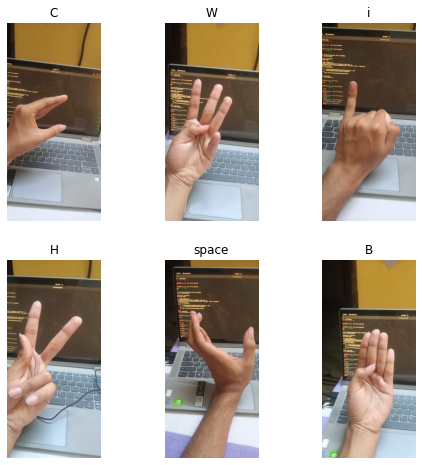

In [18]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(IMAGE_LIST[i-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(LABEL_LIST[i-1])
    
plt.show()

In [19]:
ANNOTATED_IMAGES = []
PREDICTION_LIST = []

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    for image_path in IMAGE_LIST:
        image = cv2.flip(cv2.imread(image_path), 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotated_image = image.copy()

        results = hands.process(image)
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                  annotated_image,
                  hand_landmarks,
                  mp_hands.HAND_CONNECTIONS,
                  mp_drawing_styles.get_default_hand_landmarks_style(),
                  mp_drawing_styles.get_default_hand_connections_style())

            pos_dict = handpos.get_hand_coords_frame(hand_landmarks)
            x = torch.tensor(np.array(list(pos_dict.values())).reshape(21, 3), dtype=torch.float32).to(device)
            out = model(x, edge_index, torch.tensor([0]))
            predictions = out.argmax(dim=1).item()
            predicted_letter = list(label_dict.keys())[list(label_dict.values()).index(predictions)]
            
            ANNOTATED_IMAGES.append(annotated_image)
            PREDICTION_LIST.append(predicted_letter)

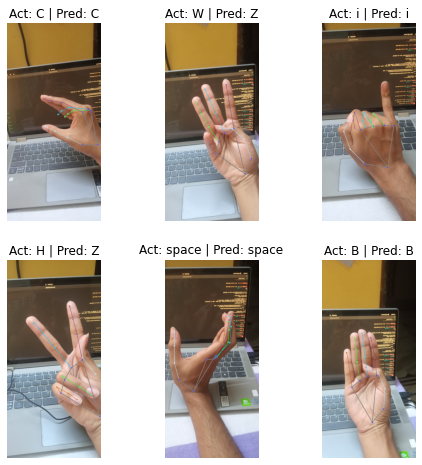

In [23]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = ANNOTATED_IMAGES[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Act: {LABEL_LIST[i-1]} | Pred: {PREDICTION_LIST[i-1]}")
    
plt.show()